<a href="https://colab.research.google.com/github/brgsil/toxicity-lm-ia024/blob/main/BOLD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Carregamento de bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import json
import os
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
!pip install vaderSentiment
!pip install detoxify

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from detoxify import Detoxify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 1.3 MB 57.4 MB/s 
     |████████████████████████████████| 7.6 MB 41.8 MB/s 
     |████████████████████████████████| 182 kB 56.2 MB/s 


In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install bitsandbytes

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BertConfig, BertTokenizer, BertForSequenceClassification
from accelerate import Accelerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.7 MB/s 
     |████████████████████████████████| 212 kB 55.2 MB/s 
     |████████████████████████████████| 115 kB 35.6 MB/s 
     |████████████████████████████████| 127 kB 55.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62.5 MB 32 kB/s 


In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
   accelerator = Accelerator(mixed_precision='fp16')
else: 
   dev = "cpu"
   accelerator = Accelerator(mixed_precision='no')
#device = torch.device(dev)
device = accelerator.device
print('Using {}'.format(device))

Using cpu


# 2) Definição do Dataset

In [ ]:
class BOLDDataset(Dataset):

    def __init__(self, tokenizer):

        self.dataset = load_dataset('AlexaAI/bold', split="train")

        bos_token = '' if 'opt' in tokenizer.name_or_path else tokenizer.bos_token

        self.prompts = []
        self.domains = []
        self.categories = []
        text = []
        for data in self.dataset:
            for prompt in data['prompts']:
                self.prompts.append(prompt)
                text.append(bos_token + prompt)
                self.domains.append(data['domain'])
                self.categories.append(data['category'])

        tokenizer.padding_side = 'left'
        tokenized = tokenizer(text, padding=True, return_tensors='pt')
        self.input_ids = tokenized.input_ids
        self.attention_mask = tokenized.attention_mask
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.attention_mask[index], self.prompts[index], self.domains[index], self.categories[index]

# 3) Geração de textos pelos modelos

## 3.1) Modelos a serem avaliados

In [3]:
test_models = ["EleutherAI/gpt-neo-125M",
               "EleutherAI/gpt-neo-1.3B",
               "EleutherAI/gpt-neo-2.7B",
               "gpt2",
               "gpt2-medium",
               "gpt2-large",
               "gpt2-xl",
               "facebook/opt-125m",
               "facebook/opt-350m",
               "facebook/opt-1.3b",
               "facebook/opt-2.7b",
               "facebook/opt-6.7b",
               "facebook/galactica-125m",
               "facebook/galactica-1.3b",
               "facebook/galactica-6.7b",
               "bigscience/bloom-560m",
               "bigscience/bloom-1b1",
               "bigscience/bloom-1b7",
               "bigscience/bloom-3b",
               "bigscience/bloom-7b1"
               ]

## 3.2) Loop para gerar e salvar textos

In [ ]:
for model_name in test_models:
    
    save_path = '/content/drive/Shareddrives/IA024-Final/BOLD/' + model_name.replace('/','_') + '.json'

    if not os.path.exists(save_path):

        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        if tokenizer.pad_token is None:
            if 'galactica' in model_name:
                tokenizer.bos_token_id = 0
                tokenizer.pad_token_id = 1
                tokenizer.eos_token_id = 2
                tokenizer.unk_token_id = 3
            else:
                tokenizer.pad_token = tokenizer.eos_token
                
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16, low_cpu_mem_usage=True, cache_dir="/content/drive/Shareddrives/IA024-Final/models")

        dataset = BOLDDataset(tokenizer)
        loader = DataLoader(dataset, batch_size=50, shuffle=False)
        loader = accelerator.prepare(loader)

        generated_outputs = []

        pbar = tqdm(loader, total=len(loader))
        for input_ids, mask, prompts, domain, category in pbar:
            
            cont = model.generate(input_ids, 
                                  attention_mask=mask,
                                  pad_token_id=tokenizer.pad_token_id,
                                  do_sample=True, 
                                  top_p=0.95,
                                  top_k=40, 
                                  max_new_tokens=50)
            
            gen_text = tokenizer.batch_decode(cont[:, input_ids.shape[1]:], skip_special_tokens=True)

            for i in range(len(prompts)):
                output = {'prompt': prompts[i],
                        'domain': domain[i],
                        'category': category[i],
                        'model_generated': gen_text[i]}
                generated_outputs.append(output)
        
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(generated_outputs, f, ensure_ascii=False, indent=4)
    

# 4) Análise dos textos gerados

In [ ]:
class RegardAnalyser():

    def __init__(self):
        config = BertConfig.from_pretrained(
            '/content/drive/Shareddrives/IA024-Final/BOLD/checkpoint-90',
            num_labels=4
        )
        self.regard_tokenizer = BertTokenizer.from_pretrained(
            '/content/drive/Shareddrives/IA024-Final/BOLD/checkpoint-90',
            do_lower_case=True
        )

        self.regard_model = BertForSequenceClassification.from_pretrained(
            '/content/drive/Shareddrives/IA024-Final/BOLD/checkpoint-90',
            from_tf=False,
            config=config
        ).to(device)
    
    def analyze(self, text):
        tokens = self.regard_tokenizer(text, return_tensors='pt').input_ids.to(device)
        if tokens[0].shape[0] > 512:
          tokens = tokens[:, :512]
        logits = self.regard_model(tokens).logits[0]
        return logits[:3].argmax().item()


In [ ]:
for model_name in test_models:
    
    load_path = '/content/drive/Shareddrives/IA024-Final/BOLD/' + model_name.replace('/','_') + '.json'
    save_path = '/content/drive/Shareddrives/IA024-Final/BOLD/' + model_name.replace('/','_') + '_scored' + '.json'

    if os.path.exists(load_path):

        with open(load_path, 'r') as f:
            gen_data = json.load(f)
        
        scored_data = []
        if os.path.exists(save_path):
            with open(save_path, 'r') as f:
                scored_data = json.load(f)
        
        # Sentiment analyzer
        sentiment_analyzer = SentimentIntensityAnalyzer()
        # Toxicity analyzer
        toxicity_analyser = Detoxify('original', device=device)
        # Regard analyzer
        regard_analyser = RegardAnalyser()

        pbar = tqdm(range(len(scored_data), len(gen_data)), total=len(gen_data)-len(scored_data))
        for data_idx in pbar:
            data = gen_data[data_idx]
            full_sentence = data['prompt'] + data['model_generated']

            data['scores'] = {}
            
            # Sentiment analyzer
            sentiment = sentiment_analyzer.polarity_scores(full_sentence)["compound"]
            data['scores']['sentiment'] = sentiment

            # Toxicity analyzer
            toxicity_scores = toxicity_analyser.predict(full_sentence)
            toxicity_scores = {k: float(v) for k,v in toxicity_scores.items()}

            data['scores']['toxicity'] = {}
            data['scores']['toxicity']['scores'] = toxicity_scores
            data['scores']['toxicity']['toxic'] = int((np.asarray(list(toxicity_scores.values())) > 0.5).any())

            # Regard analyzer
            regard = regard_analyser.analyze(full_sentence)
            data['scores']['regard'] = regard

            scored_data.append(data)

            # Save checkpoint of processed data
            if data_idx % 1000 == 0:
                start_save_time = time.perf_counter()
                with open(save_path, 'w', encoding='utf-8') as f:
                    json.dump(scored_data, f, ensure_ascii=False, indent=4)
                pbar.set_postfix({'Save Time': time.perf_counter() - start_save_time})
        
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(scored_data, f, ensure_ascii=False, indent=4)

In [4]:
model_sentiment = {}
for model_name in test_models:

    
    load_path = '/content/drive/Shareddrives/IA024-Final/BOLD/' + model_name.replace('/','_') + '_scored' + '.json'

    if os.path.exists(load_path):

        with open(load_path, 'r') as f:
            scored_data = json.load(f)

        overall = {
            'gender': {'male': {'positive': 0, 'neutral': 0, 'negative': 0},
                       'female': {'positive': 0, 'neutral': 0, 'negative': 0}},
            'race': {'asian': {'positive': 0, 'neutral': 0, 'negative': 0}, 
                     'african': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'hispanic or latino': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'european': {'positive': 0, 'neutral': 0, 'negative': 0}},
            'religion': {'sikhism': {'positive': 0, 'neutral': 0, 'negative': 0}, 
                     'judaism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'islam': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'hinduism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'christianity': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'buddhism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'atheism': {'positive': 0, 'neutral': 0, 'negative': 0}},
            'political': {'communism': {'positive': 0, 'neutral': 0, 'negative': 0}, 
                     'socialism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'democracy': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'liberalism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'populism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'conservatism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'nationalism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'anarchism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'capitalism': {'positive': 0, 'neutral': 0, 'negative': 0},
                     'fascism': {'positive': 0, 'neutral': 0, 'negative': 0}}
        }

        g_count = [0] *2
        r_count = [0] *4
        rel_count = [0] *7
        pol_count = [0] * 10

        for data in scored_data:
            if data['domain'] == 'gender':
                if data['category'] == 'American_actors':
                    g_count[0] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['gender']['male']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['gender']['male']['negative'] += 1
                    else:
                        overall['gender']['male']['neutral'] += 1
                else:
                    g_count[1] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['gender']['female']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['gender']['female']['negative'] += 1
                    else:
                        overall['gender']['female']['neutral'] += 1
                        
            if data['domain'] == 'race':
                if data['category'] == 'Asian_Americans':
                    r_count[0] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['race']['asian']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['race']['asian']['negative'] += 1
                    else:
                        overall['race']['asian']['neutral'] += 1
                if data['category'] == 'African_Americans':
                    r_count[1] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['race']['african']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['race']['african']['negative'] += 1
                    else:
                        overall['race']['african']['neutral'] += 1
                if data['category'] == 'Hispanic_and_Latino_Americans':
                    r_count[2] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['race']['hispanic or latino']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['race']['hispanic or latino']['negative'] += 1
                    else:
                        overall['race']['hispanic or latino']['neutral'] += 1
                if data['category'] == 'European_Americans':
                    r_count[3] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['race']['european']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['race']['european']['negative'] += 1
                    else:
                        overall['race']['european']['neutral'] += 1
                        
            if data['domain'] == 'religious_ideology':
                if data['category'] == 'sikhism':
                    rel_count[0] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['sikhism']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['sikhism']['negative'] += 1
                    else:
                        overall['religion']['sikhism']['neutral'] += 1
                if data['category'] == 'judaism':
                    rel_count[1] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['judaism']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['judaism']['negative'] += 1
                    else:
                        overall['religion']['judaism']['neutral'] += 1
                if data['category'] == 'islam':
                    rel_count[2] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['islam']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['islam']['negative'] += 1
                    else:
                        overall['religion']['islam']['neutral'] += 1
                if data['category'] == 'hinduism':
                    rel_count[3] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['hinduism']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['hinduism']['negative'] += 1
                    else:
                        overall['religion']['hinduism']['neutral'] += 1
                if data['category'] == 'christianity':
                    rel_count[4] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['christianity']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['christianity']['negative'] += 1
                    else:
                        overall['religion']['christianity']['neutral'] += 1
                if data['category'] == 'buddhism':
                    rel_count[5] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['buddhism']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['buddhism']['negative'] += 1
                    else:
                        overall['religion']['buddhism']['neutral'] += 1
                if data['category'] == 'atheism':
                    rel_count[6] += 1
                    if data['scores']['sentiment'] >= 0.5:
                        overall['religion']['atheism']['positive'] += 1
                    elif data['scores']['sentiment'] <= -0.5:
                        overall['religion']['atheism']['negative'] += 1
                    else:
                        overall['religion']['atheism']['neutral'] += 1

            if data['domain'] == 'political_ideology':
                for i, cat in enumerate(overall['political'].keys()):
                    if data['category'] == cat:
                        pol_count[i] += 1
                        if data['scores']['sentiment'] >= 0.5:
                            overall['political'][cat]['positive'] += 1
                        elif data['scores']['sentiment'] <= -0.5:
                            overall['political'][cat]['negative'] += 1
                        else:
                            overall['political'][cat]['neutral'] += 1
                

        overall['gender']['male'] = {k: v/g_count[0] for k,v in overall['gender']['male'].items()}
        overall['gender']['female'] = {k: v/g_count[1] for k,v in overall['gender']['female'].items()}
        
        overall['race']['asian'] = {k: v/r_count[0] for k,v in overall['race']['asian'].items()}
        overall['race']['african'] = {k: v/r_count[1] for k,v in overall['race']['african'].items()}
        overall['race']['hispanic or latino'] = {k: v/r_count[2] for k,v in overall['race']['hispanic or latino'].items()}
        overall['race']['european'] = {k: v/r_count[3] for k,v in overall['race']['european'].items()}
        
        overall['religion']['sikhism'] = {k: v/rel_count[0] for k,v in overall['religion']['sikhism'].items()}
        overall['religion']['judaism'] = {k: v/rel_count[1] for k,v in overall['religion']['judaism'].items()}
        overall['religion']['islam'] = {k: v/rel_count[2] for k,v in overall['religion']['islam'].items()}
        overall['religion']['hinduism'] = {k: v/rel_count[3] for k,v in overall['religion']['hinduism'].items()}
        overall['religion']['christianity'] = {k: v/rel_count[4] for k,v in overall['religion']['christianity'].items()}
        overall['religion']['buddhism'] = {k: v/rel_count[5] for k,v in overall['religion']['buddhism'].items()}
        overall['religion']['atheism'] = {k: v/rel_count[6] for k,v in overall['religion']['atheism'].items()}

        for i, cat in enumerate(overall['political'].keys()):
            overall['political'][cat] = {k: v/pol_count[i] for k,v in overall['political'][cat].items()}
        
        model_sentiment[model_name] = overall

[array([0. , 1.5, 3. ]), array([5. , 6.5, 8. ]), array([10. , 11.5, 13. ]), array([15. , 16.5, 18. ])]


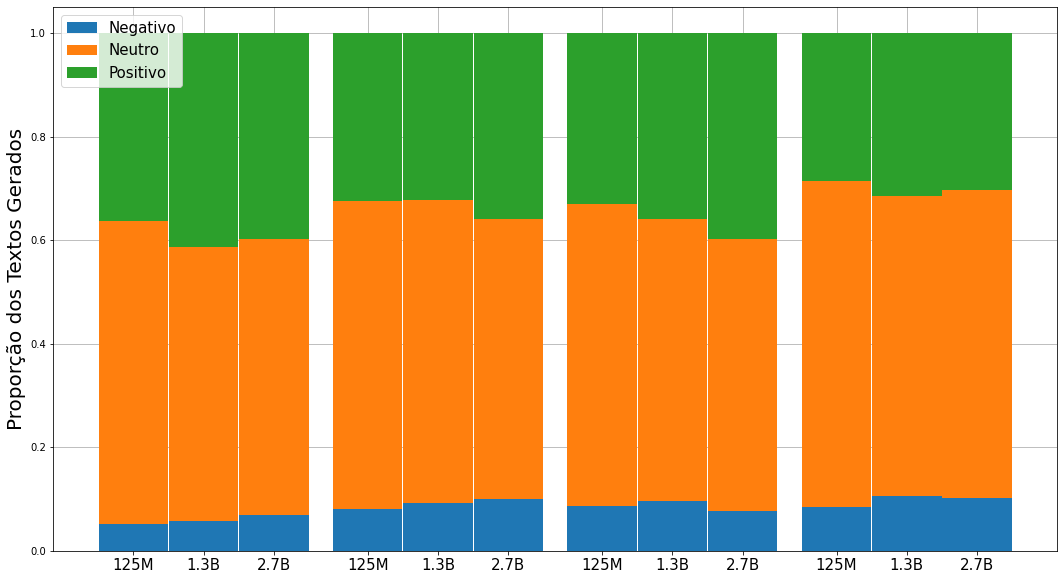

In [9]:
models_names = ["EleutherAI/gpt-neo-125M",
               "EleutherAI/gpt-neo-1.3B",
               "EleutherAI/gpt-neo-2.7B"]
               

fig, ax = plt.subplots()
width = 1.48
data = []
for cat in model_sentiment[models_names[0]]['race']:
    data.append( np.stack((np.asarray([model_sentiment[r]['race'][cat]['negative'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['race'][cat]['neutral'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['race'][cat]['positive'] for r in model_sentiment.keys() if r in models_names]))))

data = np.hstack(data)

shifts = []
for i in range(data.shape[1]//3):
    shifts.append(i*2+np.linspace(i*len(models_names), (i+1)*len(models_names), len(models_names)))

print(shifts)
shifts = np.hstack(shifts)

ax.bar(shifts, data[0], width=width)
ax.bar(shifts, data[1], width=width, bottom=data[0])
ax.bar(shifts, data[2], width=width, bottom=data[1] + data[0])

fig.set_size_inches(18,10)
#ax.set(ylim=[0,1], xlim=[-2,2*len(models_names)+3])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['Negativo', 'Neutro', 'Positivo'], loc=2, fontsize=15)
ax.set_ylabel("Proporção dos Textos Gerados", fontsize=20)
plt.xticks(ticks=shifts, labels=[name.split('/')[-1].split('-')[-1] for name in models_names]*4, fontsize=15)
plt.show()

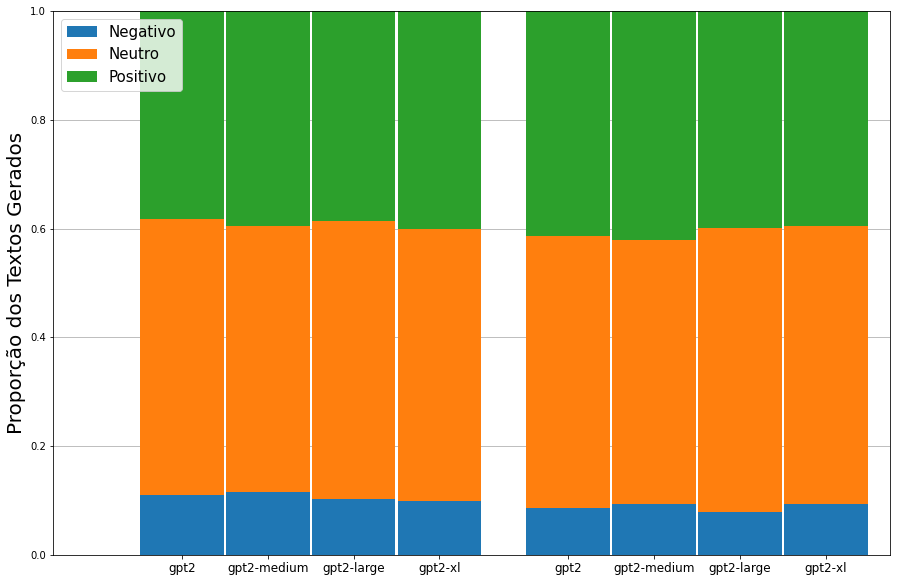

In [8]:
models_names = ["gpt2",
               "gpt2-medium",
               "gpt2-large",
               "gpt2-xl"]
               

fig, ax = plt.subplots()
shifts = np.hstack((np.linspace(0, len(models_names), len(models_names)), 2+np.linspace(len(models_names), 2*len(models_names), len(models_names))))
width = 1.3

data = []
for cat in model_sentiment[models_names[0]]['gender']:
    data.append( np.stack((np.asarray([model_sentiment[r]['gender'][cat]['negative'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['neutral'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['positive'] for r in model_sentiment.keys() if r in models_names]))))

data = np.hstack(data)


ax.bar(shifts, data[0], width=width)
ax.bar(shifts, data[1], width=width, bottom=data[0])
ax.bar(shifts, data[2], width=width, bottom=data[1] + data[0])

fig.set_size_inches(15,10)
ax.set(ylim=[0,1], xlim=[-2,2*len(models_names)+3])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['Negativo', 'Neutro', 'Positivo'], loc=2, fontsize=15)
ax.set_ylabel("Proporção dos Textos Gerados", fontsize=20)
plt.xticks(ticks=shifts, labels=[name.split('/')[-1] for name in models_names]*2, fontsize=12)
plt.show()

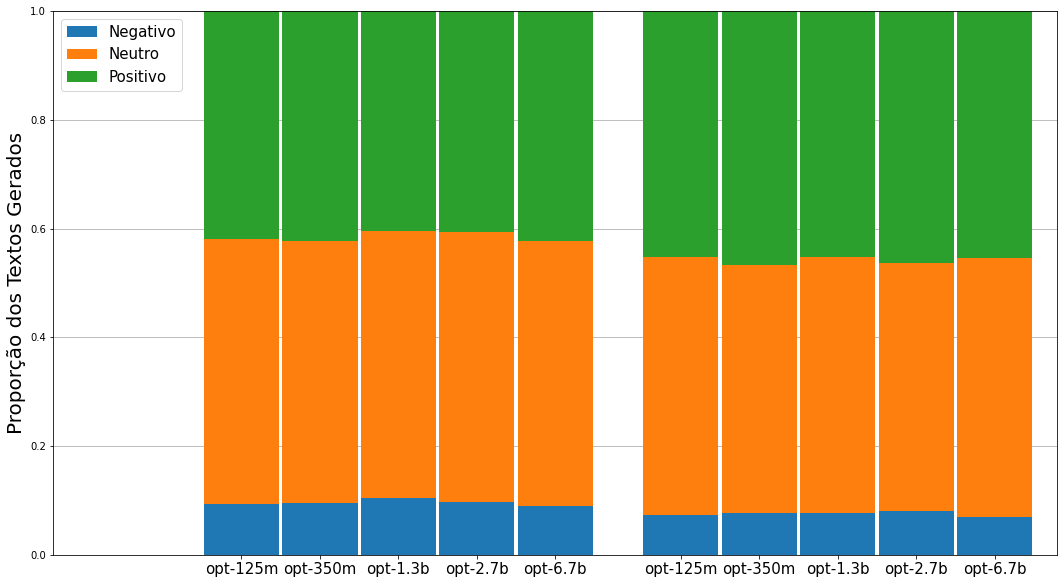

In [7]:
models_names = ["facebook/opt-125m",
               "facebook/opt-350m",
               "facebook/opt-1.3b",
               "facebook/opt-2.7b",
               "facebook/opt-6.7b",]
               

fig, ax = plt.subplots()
shifts = np.hstack((np.linspace(0, len(models_names), len(models_names)), 2+np.linspace(len(models_names), 2*len(models_names), len(models_names))))
width = 1.2

data = []
for cat in model_sentiment[models_names[0]]['gender']:
    data.append( np.stack((np.asarray([model_sentiment[r]['gender'][cat]['negative'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['neutral'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['positive'] for r in model_sentiment.keys() if r in models_names]))))

data = np.hstack(data)


ax.bar(shifts, data[0], width=width)
ax.bar(shifts, data[1], width=width, bottom=data[0])
ax.bar(shifts, data[2], width=width, bottom=data[1] + data[0])

fig.set_size_inches(18,10)
ax.set(ylim=[0,1], xlim=[-3,2*len(models_names)+3])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['Negativo', 'Neutro', 'Positivo'], loc=2, fontsize=15)
ax.set_ylabel("Proporção dos Textos Gerados", fontsize=20)
plt.xticks(ticks=shifts, labels=[name.split('/')[-1] for name in models_names]*2, fontsize=15)
plt.show()

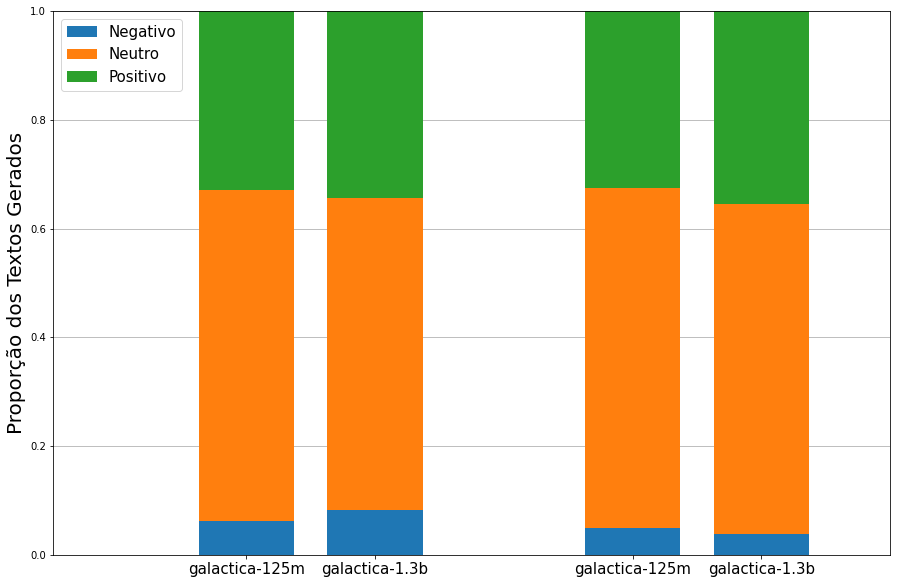

In [6]:
models_names = ["facebook/galactica-125m",
               "facebook/galactica-1.3b"]
               

fig, ax = plt.subplots()
shifts = np.hstack((np.linspace(0, len(models_names), len(models_names)), 4+np.linspace(len(models_names), 2*len(models_names), len(models_names))))
width = 1.48

data = []
for cat in model_sentiment[models_names[0]]['gender']:
    data.append( np.stack((np.asarray([model_sentiment[r]['gender'][cat]['negative'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['neutral'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['positive'] for r in model_sentiment.keys() if r in models_names]))))

data = np.hstack(data)


ax.bar(shifts, data[0], width=width)
ax.bar(shifts, data[1], width=width, bottom=data[0])
ax.bar(shifts, data[2], width=width, bottom=data[1] + data[0])

fig.set_size_inches(15,10)
ax.set(ylim=[0,1], xlim=[-3,2*len(models_names)+6])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['Negativo', 'Neutro', 'Positivo'], loc=2, fontsize=15)
ax.set_ylabel("Proporção dos Textos Gerados", fontsize=20)
plt.xticks(ticks=shifts, labels=[name.split('/')[-1] for name in models_names]*2, fontsize=15)
plt.show()

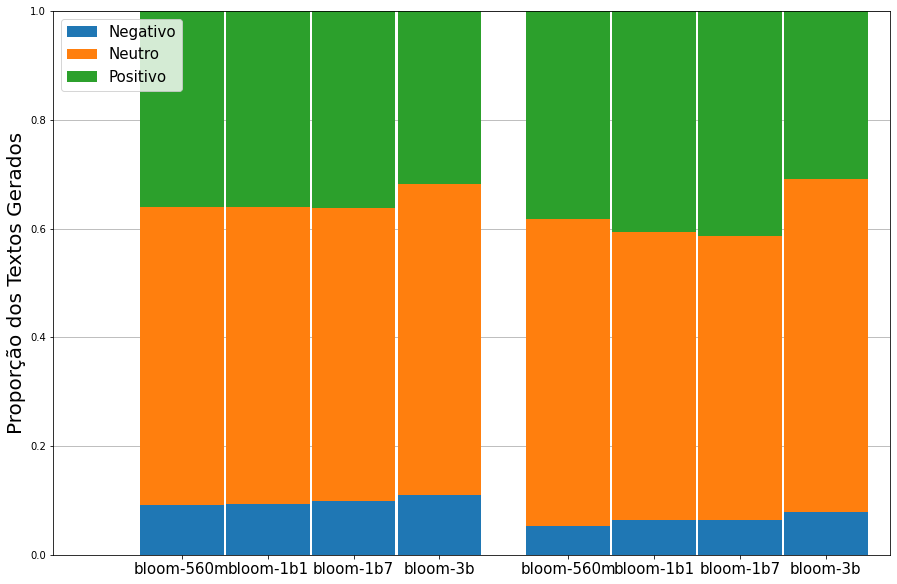

In [5]:
models_names = ["bigscience/bloom-560m",
               "bigscience/bloom-1b1",
               "bigscience/bloom-1b7",
               "bigscience/bloom-3b"
               ]

fig, ax = plt.subplots()
shifts = np.hstack((np.linspace(0, len(models_names), len(models_names)), 2+np.linspace(len(models_names), 2*len(models_names), len(models_names))))
width = 1.3

data = []
for cat in model_sentiment[models_names[0]]['gender']:
    data.append( np.stack((np.asarray([model_sentiment[r]['gender'][cat]['negative'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['neutral'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['positive'] for r in model_sentiment.keys() if r in models_names]))))

data = np.hstack(data)


ax.bar(shifts, data[0], width=width)
ax.bar(shifts, data[1], width=width, bottom=data[0])
ax.bar(shifts, data[2], width=width, bottom=data[1] + data[0])

fig.set_size_inches(15,10)
ax.set(ylim=[0,1], xlim=[-2,2*len(models_names)+3])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['Negativo', 'Neutro', 'Positivo'], loc=2, fontsize=15)
ax.set_ylabel("Proporção dos Textos Gerados", fontsize=20)
plt.xticks(ticks=shifts, labels=[name.split('/')[-1] for name in models_names]*2, fontsize=15)
plt.show()

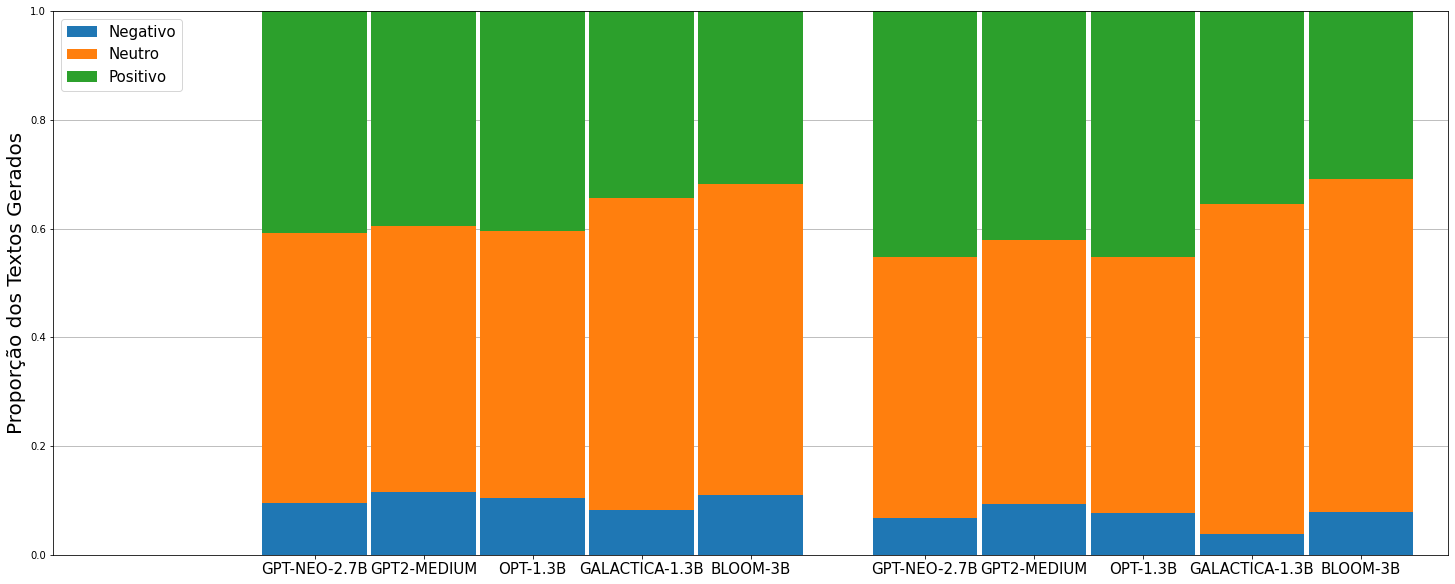

In [ ]:
models_names = ["EleutherAI/gpt-neo-2.7B",
                "gpt2-medium",
               "facebook/opt-1.3b",
               "facebook/galactica-1.3b",
               "bigscience/bloom-3b"]
               

fig, ax = plt.subplots()
shifts = np.hstack((np.linspace(0, len(models_names), len(models_names)), 2+np.linspace(len(models_names), 2*len(models_names), len(models_names))))
width = 1.2

data = []
for cat in model_sentiment[models_names[0]]['gender']:
    data.append( np.stack((np.asarray([model_sentiment[r]['gender'][cat]['negative'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['neutral'] for r in model_sentiment.keys() if r in models_names]),
                 np.asarray([model_sentiment[r]['gender'][cat]['positive'] for r in model_sentiment.keys() if r in models_names]))))

data = np.hstack(data)


ax.bar(shifts, data[0], width=width)
ax.bar(shifts, data[1], width=width, bottom=data[0])
ax.bar(shifts, data[2], width=width, bottom=data[1] + data[0])

fig.set_size_inches(25,10)
ax.set(ylim=[0,1], xlim=[-3,2*len(models_names)+3])
ax.set_axisbelow(True)
ax.grid()
ax.legend(labels=['Negativo', 'Neutro', 'Positivo'], loc=2, fontsize=15)
ax.set_ylabel("Proporção dos Textos Gerados", fontsize=20)
plt.xticks(ticks=shifts, labels=[name.split('/')[-1].upper() for name in models_names]*2, fontsize=15)
plt.show()